# Aim:


To train a UNet model to predict or segment the Atrium from an MRI image.

The task is carried out using Pytorch in a Jupyter Notebook IDE.

# Dataset description: 

The medical segmentation images used here were provided by Decathalon (http://medicaldecathlon.com/)<br /> (Data License: https://creativecommons.org/licenses/by-sa/4.0/)<br />.

The Decathalon challenge comprise 10 medical segmentation tasks including atrium segmentation. 

For the Atrium segmentation task, the data comprise of 20 patients MR1 scans of the heart and corresponding gound truth masks. That is 4542 2D MRI slices and therir corresponding label. 16 patients are used for training and the remaining 4 for validation.

In this work, slices would be used in place of volumes due to memory constraints. 





### Data preparation and import of libraries

I have done the following to prepare the data:

1. Create a list of all 2D slices
2. Extract and load slice with the corresponding label mask as a precheck
3. Visualised the data

In [121]:
# Library import

%matplotlib notebook
from pathlib import Path
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from celluloid import Camera
from IPython.display import HTML
import imgaug.augmenters as iaa

### A function to switch between the MRI and labels path

The function below automatically replaces "imagesTr" with "labelsTr" in the filepaths so that we can easily switch between mri images and label masks

In [122]:
Base_path = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation\Task02_Heart')
root = Path(Base_path/'Task02_Heart/imagesTr/')
label = Path(Base_path/'Task02_Heart/labelsTr')

In [123]:
def change_img_to_label_path(path):
    parts = list(path.parts)
    parts[parts.index('imagesTr')] = 'labelsTr'
    return Path(*parts)   

In [124]:
# Testing that the function works
sample_path = list(root.glob('la*'))[0]
sample_path_label = change_img_to_label_path(sample_path)
sample_path, sample_path_label

(WindowsPath('C:/Users/Owner/OneDrive - University of Eastern Finland/Desktop/DL/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/06-Atrium-Segmentation/Task02_Heart/Task02_Heart/imagesTr/la_003.nii.gz'),
 WindowsPath('C:/Users/Owner/OneDrive - University of Eastern Finland/Desktop/DL/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/06-Atrium-Segmentation/Task02_Heart/Task02_Heart/labelsTr/la_003.nii.gz'))

### Loading the data which is in NIfTI format

In [125]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

mri = data.get_fdata()
mask = label.get_fdata().astype(np.uint8)

Inspecting the image using celliloid and HTML5 video

<IPython.core.display.Javascript object>


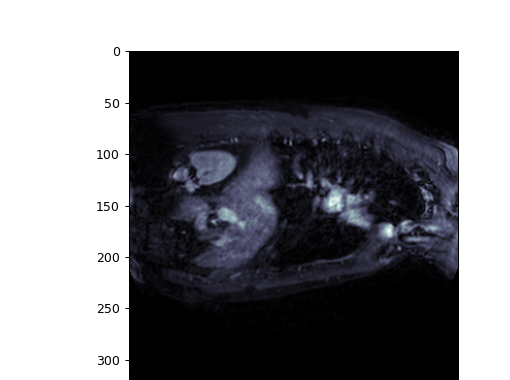

In [126]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap='bone')
    mask_ = np.ma.masked_where(mask[:,:, i] == 0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap='autumn')
    camera.snap()
animation = camera.animate()

In [127]:
# An animation video of an MRI and Mask
HTML(animation.to_html5_video()) 

C:\Users\Owner\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Owner\anaconda3\envs\pytorchenv\lib\site-packages\matplotlib\image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


# Data Preprocessing

The following would be done:
1. Normalization using the  image mean and standard deviation
2. Croping of the images to optimize for training
3. Standization of the images into 0 - 1 range
4. Transform data to 2D slices to optimize training
    

In [128]:
# A functions to normalize and standardize the images

def normalize(full_volume):
    'This function takes in the full mri volume and normalize using the mean and std'
    
    mu  = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized 

def standardize(normalized):
    'This function normalize the data into the range 0 -1'
    
    standardized_data = (normalized - normalized.min())/(normalized.max() - normalized.min())
    return standardized_data

### Process the images and save them in a 'train' and 'val' folder.

Since training is done using slices, the slices are extracted and saved as npy files in the respective folders

In [130]:
# Create a list of all the image files
Base_path = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation\Task02_Heart')
root = Path(Base_path/'Task02_Heart/imagesTr/')
label = Path(Base_path/'Task02_Heart/labelsTr')
all_files = list(root.glob('la*'))

In [131]:
# Base folder path 
Base = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation')

# Created folder to save processed images
save_root = Path(Base/'processed/')  

for count, mri_path in enumerate(tqdm(all_files)):
    
    # Change from image to label path and load the labels
    label_path = change_img_to_label_path(mri_path) 
    
    mri = nib.load(mri_path)
    mri_data = mri.get_fdata()
    
    label = nib.load(label_path)
    label_data = label.get_fdata().astype(np.uint8)
    
    # Crop the images to optimize for training time
    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]
    
    #Normalize and standadize the mri data
    Normalized_mri = normalize(mri_data)
    Standardized_mri = standardize(Normalized_mri)

    # Seperate in the folders into train and val
    if count < 17:  # 16 patients are used for training 
        current_path = save_root/'train'/str(count)
    else:
        current_path = save_root/'val'/str(count)
            
    # Loop over the slices in the full volume and store the images and labels in the data/masks directory

    for i in range(Standardized_mri.shape[-1]): #-1 is used to access the sclices of the images (images format H(256)XW(256)XD(110))
        slice = Standardized_mri[:,:,i]
        mask = label_data[:,:,i]
        
        slice_path = current_path/'data' #Save MRI data
        mask_path = current_path/'masks' #Save mask
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)

  0%|          | 0/20 [00:00<?, ?it/s]

#### Sample plot a single file 


<IPython.core.display.Javascript object>


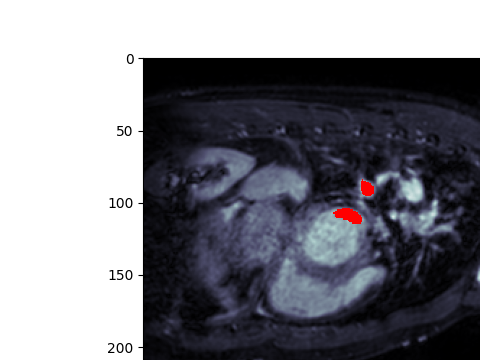

In [136]:
path = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation\processed\train\0\\')
file = '50.npy' # This file is randomly choosen for import
img = np.load(path/'data'/file)
mask = np.load(path/'masks'/file)

plt.figure()
plt.imshow(img, cmap = 'bone')
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, cmap='autumn')

## Dataset class 

This would augument and feed the MRI slices and the corresponding segmentation mask to the network during training.

Tasks accomplished in this section:
1. A list of all 2D slices is created 
2. The corresonding label path for each slice is extracted 
3. Loading the slice and label 
4. Augument the slices and labels together 
5. Return the slice and mask


In [48]:
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


In [137]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        self.all_files = self.extract_files(root)
        self.augment_params = augment_params
        
    @staticmethod
    def extract_files(root):
        files = []
        for subject in root.glob('*'):
            slice_path = Path(subject/'data')
            for slice in slice_path.glob('*.npy'):
                files.append(slice)  
        return files
    
    
    @staticmethod
    
    def change_img_to_label_path(path):
        parts = list(path.parts)
        parts[parts.index('data')]= 'masks'
        return Path(*parts)
    
    def augment(self, slice, mask):
        
        random_seed = torch.randint(0, 1000000, (1,)).item()
        imgaug.seed(random_seed)   
        
        
        mask = SegmentationMapsOnImage(mask, mask.shape)
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)
        mask_aug = mask_aug.get_arr()
        return slice_aug, mask_aug
    
    def __len__(self):
        
        return len(self.all_files)
    
    
    def __getitem__(self, idx):
        
        file_path = self.all_files[idx]
        mask_path = self.change_img_to_label_path(file_path)
        slice = np.load(file_path).astype(np.float32)
        mask = np.load(mask_path)
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)
    

# Pytorch expects the input of shape BxCxHxW, where B corresponds to the batch size, C to the channels, H to the height and W to Width.
# As our data is of shape (HxW), we need to manually add the C axis by using expand_dims. The batch dimension is added by the dataloader    

#### Testing the data augmentation method

<IPython.core.display.Javascript object>


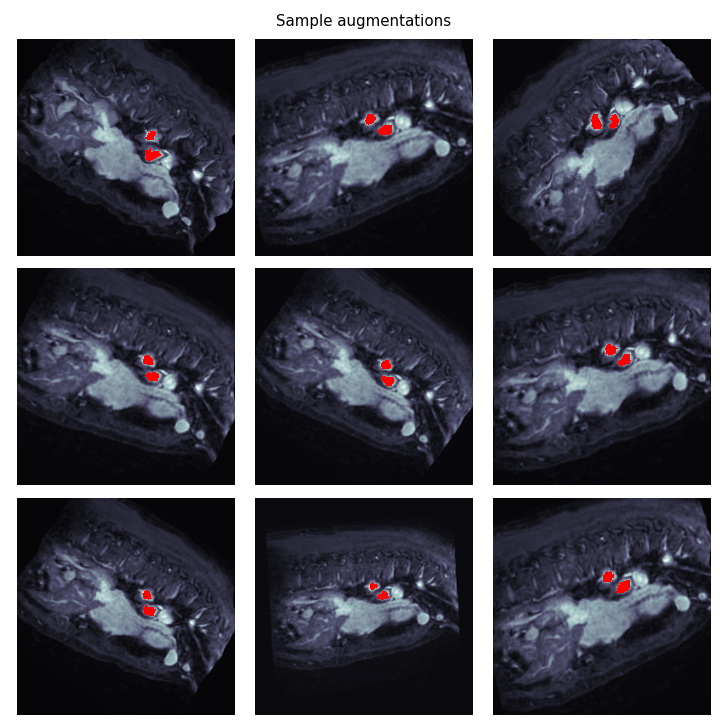

In [52]:
# Augumentation technique
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

# Creating the dataset objects 
path = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation\processed\\')
path = Path(base_path/'train/')
dataset = CardiacDataset(path, seq)

fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()

## Creating the UNET from scratch

First define a double convolution block. These double convolution are used between the down and up convolution. Next, the double convolution blocks are combined with maxpooling for downsampling and deconding, then with upsample for upsampling.

In [70]:
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        
        
        super().__init__()
        self.step = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, 3, padding = 1),
                                       torch.nn.ReLU(),
                                       torch.nn.Conv2d(out_channels, out_channels, 3, padding = 1),
                                       torch.nn.ReLU())
        
    def forward(self, X):
        return self.step(X)

In [71]:
class UNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = DoubleConv(1, 64)
        self.layer2 = DoubleConv(64, 128)
        self.layer3 = DoubleConv(128, 256)
        self.layer4 = DoubleConv(256, 512)
        
        self.layer5 = DoubleConv(512+256, 256)
        self.layer6 = DoubleConv(256+128, 128)
        self.layer7 = DoubleConv(128+64, 64)
        self.layer8 = torch.nn.Conv2d(64, 1, 1)
        
        self.maxpool = torch.nn.MaxPool2d(2)
    
    def forward(self, x):
        
        x1 = self.layer1(x)
        x1m = self.maxpool(x1)
        
        x2 = self.layer2(x1m)
        x2m = self.maxpool(x2)
        
        x3 = self.layer3(x2m)
        x3m = self.maxpool(x3)
        
        x4 = self.layer4(x3m)
                
        x5 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x4)
        x5 = torch.cat([x5, x3], dim=1)
        x5 = self.layer5(x5)
        
        x6 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x5)
        x6 = torch.cat([x6, x2], dim=1)
        x6 = self.layer6(x6)
        
        x7 = torch.nn.Upsample(scale_factor=2, mode="bilinear")(x6)
        x7 = torch.cat([x7, x1], dim=1)
        x7 = self.layer7(x7)
        
        ret = self.layer8(x7)
        return ret    

## Compute the Dice Loss based on the equation below
Segmentation models perform better when using a Dice Loss instead of Cross-Entropy.<br />
The Dice Loss is defined as:
$$ L(\hat{y}, y) = 1-\frac{2 |\hat{y} \cap y|}{|\hat{y}| + |y|}$$

In [74]:
class DiceLoss(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        # Flatten label and prediction tensors
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        counter = (pred * mask).sum()  # Numerator       
        denum = pred.sum() + mask.sum() + 1e-8  # Denominator. Add a small number to prevent NANS
        dice =  (2*counter)/denum
        return 1 - dice


## Creating the dataset to be fed into the model

First the data augmentation pipeline is created and next the train and validation dataloaders are created.

In [140]:
# Augumentation technique to be applied
seq = iaa.Sequential([
    iaa.Affine(scale =(0.85, 1.15),
               rotate=(-45, 45)),
    iaa.ElasticTransformation()          
])

In [84]:
# Creating the dataset objects based on the training and validation data paths
path = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation\processed\\')
Train_path = Path(base_path/'train/')
Val_path = Path(base_path/'val/')
              
train_dataset = CardiacDataset(Train_path, seq)
val_dataset = CardiacDataset(Val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


In [101]:
batch_size = 8
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Complete segmentation model:


In [112]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        self.log('Train_Dice', loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Train')
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        self.log('Val_Dice', loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), 'Val')
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0] == 0, pred[0][0])
        axis[0].imshow(mask_, alpha=0.6)
                                   
                                   
        axis[1].imshow(mri[0][0], cmap='bone')
        mask_ = np.ma.masked_where(mask[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
        self.logger.experiment.add_figure(name, fig, self.global_step)
                                   
    def configure_optimizers(self):
        return [self.optimizer]

In [113]:
# Instanciate the model and set the random seed
torch.manual_seed(0)
model = AtriumSegmentation()

In [114]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=10,
    mode='min')

In [115]:
# Create the trainer
cpus = 1 #TODO
trainer = pl.Trainer(logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=75)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs



  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


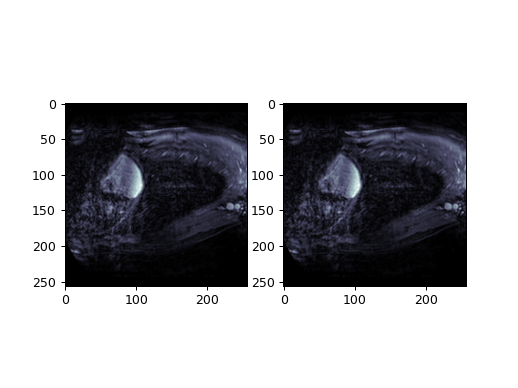

C:\Users\Owner\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

<IPython.core.display.Javascript object>


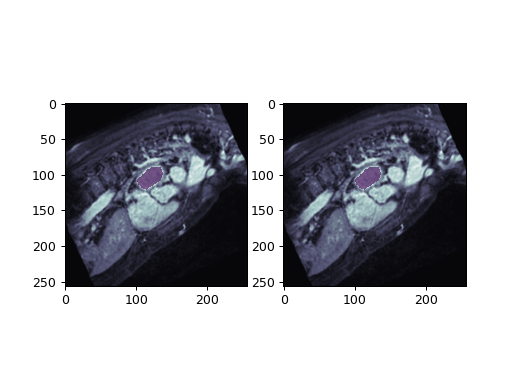

<IPython.core.display.Javascript object>


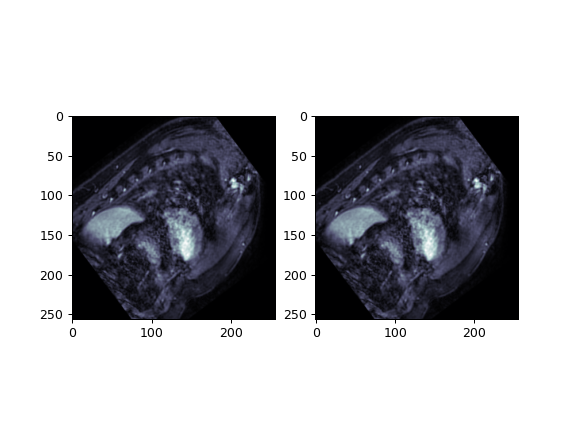

<IPython.core.display.Javascript object>


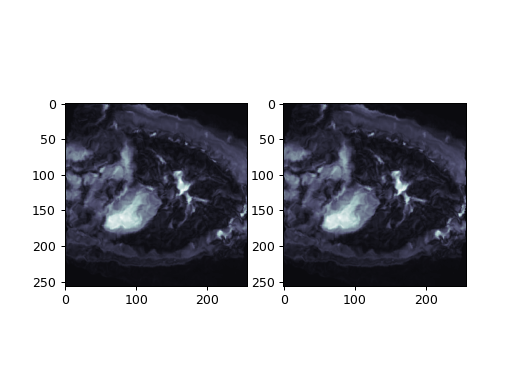

<IPython.core.display.Javascript object>


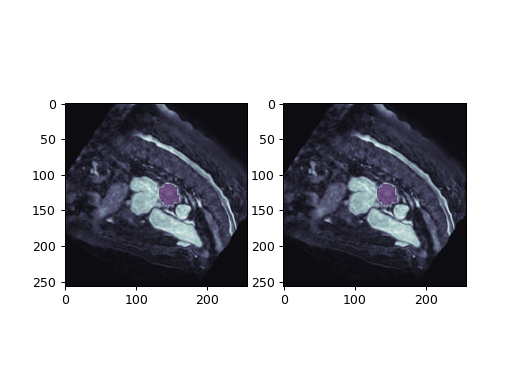

<IPython.core.display.Javascript object>


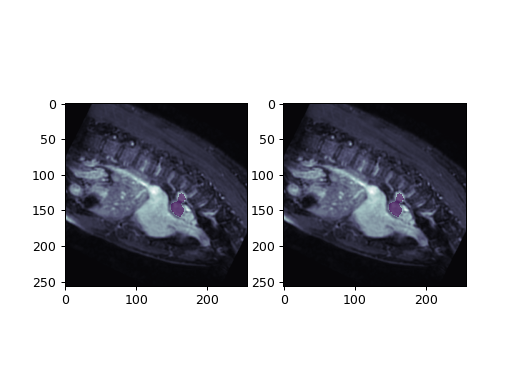

Validating: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>


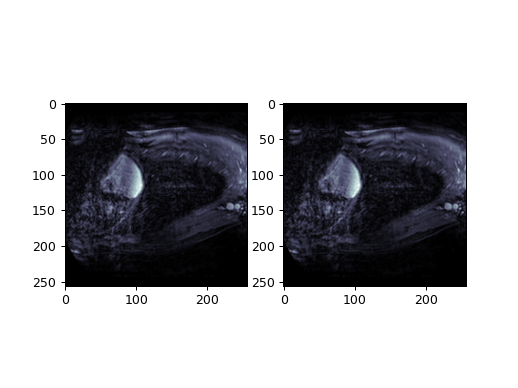

MisconfigurationException: ModelCheckpoint(monitor='Val Dice') not found in the returned metrics: ['Train_Dice', 'Val_Dice']. HINT: Did you call self.log('Val Dice', value) in the LightningModule?

In [116]:
# Fit the trainer
trainer.fit(model, train_loader, val_loader)

## Evaluating the model

In [117]:
model = AtriumSegmentation.load_from_checkpoint("weights/70.ckpt")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

In [118]:
# Evaluate the complete validation dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval();
model.to(device);

preds = []
labels = []

for slice, label in tqdm(val_dataset):
    slice = torch.tensor(slice).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slice)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [ ]:
# Compute the overall DICE score

dice_score = 1-DiceLoss()(torch.from_numpy(preds), torch.from_numpy(labels).unsqueeze(0).float())
print(f"The Val Dice Score is: {dice_score}")

## Testing the capacity of the model to predict the position of the artrium for a single subject

In [143]:
Base_path =  Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\06-Atrium-Segmentation\\')
subject = Path(Base_path/"Task02_Heart/Task02_Heart/imagesTs/la_002.nii.gz")
subject_mri = nib.load(subject).get_fdata()

In [144]:
# Standardize, normalize and crop the image
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))
standardized_scan.shape

(256, 256, 140)

In [145]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slice = standardized_scan[:,:,i]
    with torch.no_grad():
        pred = model(torch.tensor(slice).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

C:\Users\Owner\anaconda3\envs\pytorchenv\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:,:,i], cmap="bone")
    mask = np.ma.masked_where(preds[i]==0, preds[i])
    plt.imshow(mask, alpha=0.5, cmap="autumn")
    
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation

In [ ]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video